MASSACHUSETTS INSTITUTE OF TECHNOLOGY<br>
SYSTEM DESIGN & MANAGEMENT<br>
Author: R. Chadwick Holmes<br>
Date: March 22, 2021<br>
Last Updated: December 7, 2021<br><br>

**Label: Final Workflow, Script 2**<br>
Script Purpose:<br>
Script for exploring supervised learning applied to the data set and the impact of uncertainties.
<br><br>


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [2]:
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install dataprep --no-binary dataprep

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download

In [3]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import tree

from collections import Counter

import statsmodels.api as sm
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
import pickle as pkl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import seaborn as sns

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

### Set seed for randomized elements in script

In [5]:
seed = 43

# define extent for mapping
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
extent = [xmin,xmax,ymin,ymax]

### Mount Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/Colab Notebooks/Data'

Mounted at /content/drive


### Helper Functions

In [35]:
## Set Plotting Parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [36]:
myprojection = ccrs.PlateCarree()

def createBasemap():
    expl_area = datafolder / 'Exploration_area.shp'
    expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

    rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
    #stamen_terrain = cimgt.Stamen('terrain-background')

    # generate plot of NM with river and stock image
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=myprojection)

    # Add the Stamen data at zoom level 9.
    ax.stock_img()
    #ax.add_image(stamen_terrain, 9)
    
    ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    ax.add_feature(expl_area_feat, facecolor='None', edgecolor='r', linewidth=2, alpha = 0.5)

    ax.set_extent(extent,crs=myprojection)
    
    return ax

### Load data from saved pickle file

In [37]:
datafolder = Path(path) 

with open(datafolder/ "wellsp8_shared.pkl","rb") as handle: 
#with open(datafolder/ "wellsp4_shared.pkl","rb") as handle: 
#with open(datafolder/ "wells_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
    
# unpack
fulldf = datadict['data']
coords = datadict['coords']
X_train = datadict['X_train'].reset_index(drop=True)
X_val   = datadict['X_val'].reset_index(drop=True)
X_test  = datadict['X_test'].reset_index(drop=True)
yr_train = datadict['yr_train'].reset_index(drop=True)
yr_val   = datadict['yr_val'].reset_index(drop=True)
yr_test  = datadict['yr_test'].reset_index(drop=True)
yc_train = datadict['yc_train'].reset_index(drop=True)
yc_val   = datadict['yc_val'].reset_index(drop=True)
yc_test  = datadict['yc_test'].reset_index(drop=True)

In [38]:
print(X_train.shape[0]+X_test.shape[0]+X_val.shape[0])
X_train.head(2)

5344


,DEM,DEMGrad,Gravity,GravityGrad,Magnetic,MagneticGrad,DosageRate,WTDepth,WTGrad,BasementDepth,CrustalThickness,AirTemperature,Precipitation,StrainRate,QFaults,StateFaults,Drainage,VolcanicDikes,SiGeothermometry,Lithium,Boron,HeatFlow,Earthquakes,Vents,Springs,GeothermGrad_2class
0,1186.0,0.000721,-161.180160,0.108319,-107.463425,0.561295,60.852009,22.27627,99243.062500,3698.876465,27.677557,17.012707,252.241196,1.210380,6.670007,7.919702,6.763772,0.002239,48.957527,0.118951,0.157249,119.273399,-25.697401,-25.798687,-26.834686,"[60, 9999)"
1,1254.0,0.003242,-160.070038,0.038074,-7.054341,0.933958,42.791359,329.38385,52782.089844,5233.645996,27.727911,17.137991,248.240890,0.559776,4.711527,2.943224,2.315694,0.000000,49.298653,0.159062,0.336346,97.183159,-26.302048,-25.682467,-28.121691,"[0, 60)"


## Test that plotting works

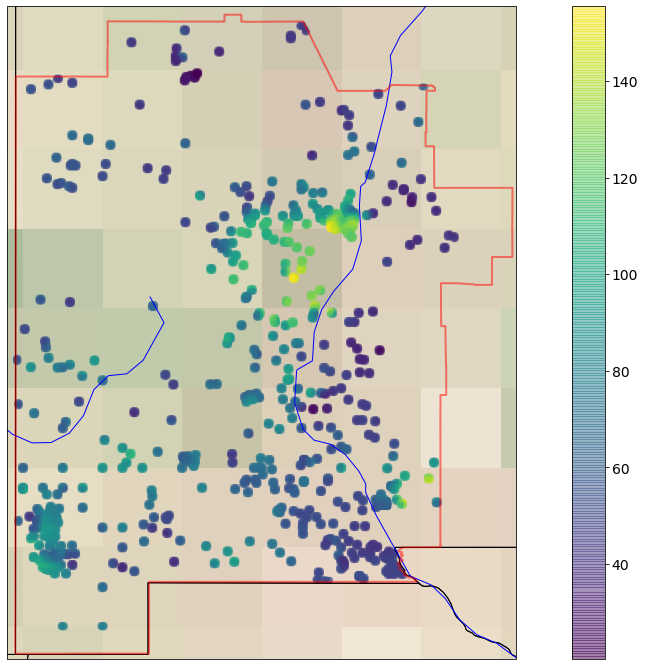

In [39]:
ax = createBasemap();

gdf = gpd.GeoDataFrame(fulldf.copy(deep=True), 
                       geometry=gpd.points_from_xy(coords.Longitude, coords.Latitude),
                       crs = {'init': 'epsg:4326'})
pc = ax.scatter(coords.Longitude,
                coords.Latitude,
                cmap='viridis',
                c=gdf['DosageRate'],
                #c=gdf['CutCategory'].cat.codes,
                #vmin=0, vmax=125,
                alpha=0.5,
                transform=myprojection);
plt.colorbar(pc);

In [40]:
X_train

,DEM,DEMGrad,Gravity,GravityGrad,Magnetic,MagneticGrad,DosageRate,WTDepth,WTGrad,BasementDepth,CrustalThickness,AirTemperature,Precipitation,StrainRate,QFaults,StateFaults,Drainage,VolcanicDikes,SiGeothermometry,Lithium,Boron,HeatFlow,Earthquakes,Vents,Springs,GeothermGrad_2class
0,1186.000000,0.000721,-161.180160,0.108319,-107.463425,0.561295,60.852009,22.276270,99243.062500,3698.876465,27.677557,17.012707,252.241196,1.210380,6.670007,7.919702,6.763772,0.002239,48.957527,0.118951,0.157249,119.273399,-25.697401,-25.798687,-26.834686,"[60, 9999)"
1,1254.000000,0.003242,-160.070038,0.038074,-7.054341,0.933958,42.791359,329.383850,52782.089844,5233.645996,27.727911,17.137991,248.240890,0.559776,4.711527,2.943224,2.315694,0.000000,49.298653,0.159062,0.336346,97.183159,-26.302048,-25.682467,-28.121691,"[0, 60)"
2,2350.555908,6.906147,-233.164505,0.066705,114.935989,0.795401,92.360863,89.718979,583933.500000,2530.235107,39.312431,8.144773,389.465485,2.762756,1.858823,20.398287,10.458104,2.128305,45.456074,0.044062,0.068122,97.860840,-25.850922,-26.313894,-26.007340,"[0, 60)"
3,1586.078003,6.017325,-167.394608,0.057491,-17.355005,0.432171,68.528870,179.649399,579016.937500,714.801819,30.320206,14.466916,356.917725,1.066924,0.926434,7.850878,15.396860,0.787906,72.383125,0.121562,0.139500,99.136543,-27.420937,-28.138601,-26.241201,"[60, 9999)"
4,1444.845337,1.066310,-173.322998,0.255457,-126.876808,0.881720,39.208580,111.572441,348436.125000,1473.565918,30.912121,14.943424,246.000763,1.919058,0.253908,1.436236,3.208686,0.261231,45.481251,0.426560,0.415235,76.388886,-28.807459,-26.616720,-26.219505,"[0, 60)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3735,1259.938721,1.878086,-153.975601,0.009474,-87.923645,0.788798,46.726788,323.775238,147369.609375,4318.788574,27.759548,16.905806,248.703796,0.863017,8.333798,6.745296,1.815047,0.000000,69.778595,0.145308,0.557015,86.992577,-27.598793,-24.854114,-28.696430,"[60, 9999)"
3736,1398.835815,1.109286,-159.363968,0.149546,-89.610313,2.986524,57.404159,293.691071,213913.937500,2036.542602,29.230219,15.489517,296.351959,1.342794,0.433916,12.253046,8.045888,0.153706,69.213669,0.074952,0.108913,99.795898,-28.300367,-26.883755,-26.580793,"[60, 9999)"
3737,1613.639770,5.454956,-192.250122,0.097025,-14.643636,0.042450,115.036835,56.865700,816773.687500,1787.674439,32.587483,14.296038,269.624054,1.518461,10.152210,5.654004,19.675222,0.510195,56.281780,0.210359,0.118177,100.608864,-27.166805,-25.891001,-26.006329,"[0, 60)"
3738,1251.000000,0.001379,-140.588272,0.205345,-34.099434,0.464687,39.924686,273.103027,424635.562500,3262.402344,27.838087,16.928392,249.908966,0.965233,8.450678,9.172159,4.620396,0.000000,79.186760,0.097674,0.696319,84.765686,-28.953011,-24.652866,-29.042904,"[0, 60)"


## Logistic Regression
### Use 4-class model based on cut-offs defined in literature
### Dropping AirTemperature

In [41]:
dropcols = ['AirTemperature','GeothermGrad_2class'] 

# use original data set (imbalanced)
Xtr = X_train.drop(dropcols,axis=1)
Xvl = X_val.drop(dropcols,axis=1)
Xts = X_test.drop(dropcols,axis=1)

# scale and transform data
# note: using StandardScaler + PowerTransformer due to bug found in PowerTransformer with standard=True alone
# i.e., it converts DEM and Precipitation to single value features
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)
pl = Pipeline(steps=[('scale',sc),('powertransform',pt)])

colnames = [x for x in Xtr.columns if x not in dropcols]
print(colnames)
pl.fit(Xtr[colnames],yc_train)
Xtrsc = pd.DataFrame(pl.transform(Xtr[colnames]), columns=colnames)
Xvlsc = pd.DataFrame(pl.transform(Xvl[colnames]), columns=colnames)
Xtssc = pd.DataFrame(pl.transform(Xts[colnames]), columns=colnames)

['DEM', 'DEMGrad', 'Gravity', 'GravityGrad', 'Magnetic', 'MagneticGrad', 'DosageRate', 'WTDepth', 'WTGrad', 'BasementDepth', 'CrustalThickness', 'Precipitation', 'StrainRate', 'QFaults', 'StateFaults', 'Drainage', 'VolcanicDikes', 'SiGeothermometry', 'Lithium', 'Boron', 'HeatFlow', 'Earthquakes', 'Vents', 'Springs']


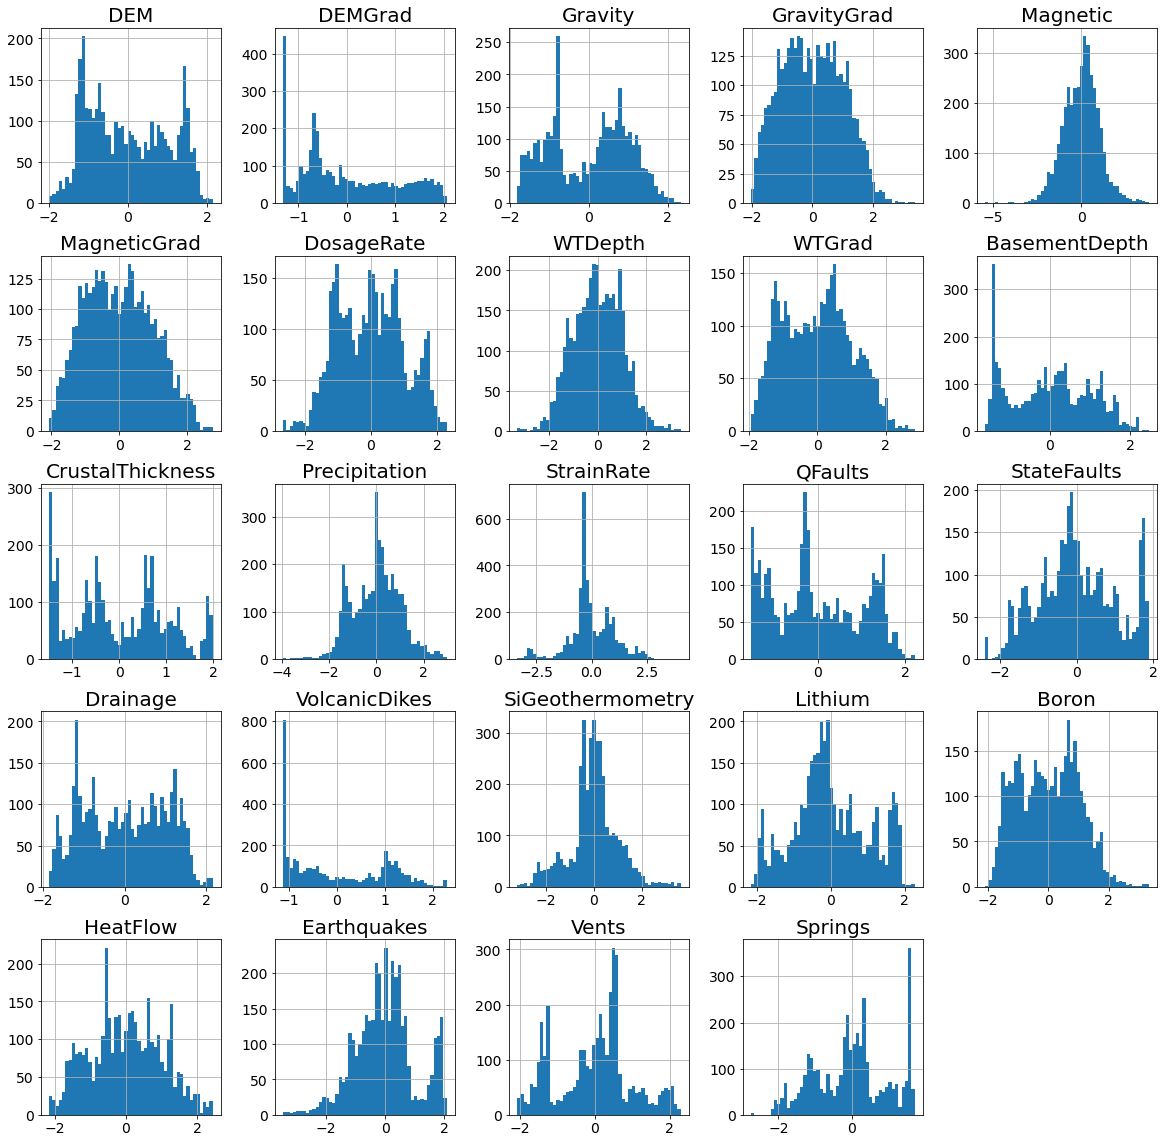

In [14]:
Xtrsc.hist(figsize=(20,20),bins=50);

In [42]:
# 4-class model once multi-class methods are ready
yc_val4   = yc_val['GeothermGrad_4class'].cat.codes
yc_test4  = yc_test['GeothermGrad_4class'].cat.codes
yc_train4 = yc_train['GeothermGrad_4class'].cat.codes

In [43]:
print('train:')
counter = Counter(yc_train4)
for k,v in counter.items():
	per = v / len(yc_train4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
print('\nvalidate:')
counter = Counter(yc_val4)
for k,v in counter.items():
	per = v / len(yc_val4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

print('\ntest:')
counter = Counter(yc_test4)
for k,v in counter.items():
	per = v / len(yc_test4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

#print(list(Xtr))

train:
Class=3, n=1558 (41.658%)
Class=2, n=1420 (37.968%)
Class=0, n=129 (3.449%)
Class=1, n=633 (16.925%)

validate:
Class=0, n=27 (3.367%)
Class=2, n=305 (38.030%)
Class=1, n=136 (16.958%)
Class=3, n=334 (41.646%)

test:
Class=2, n=304 (37.905%)
Class=1, n=136 (16.958%)
Class=3, n=334 (41.646%)
Class=0, n=28 (3.491%)


### Hyperparameter Tuning

In [44]:
from sklearn.metrics import roc_auc_score

# encode classification variable
le = LabelEncoder()
le.fit(yc_train4)
yenc_trn = le.transform(yc_train4)
yenc_val = le.transform(yc_val4)
yenc_tst = le.transform(yc_test4)

Xtrnvalsc=pd.concat([Xtrsc[colnames],Xvlsc[colnames]])
yenc_trnval=np.append(yenc_trn,yenc_val)

### K-fold Stratified Sampling

In [45]:
# example of stratified k-fold cross-validation with an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, 
                        shuffle=True, 
                        random_state=seed)
mod_logr = LogisticRegression(fit_intercept=True, 
                              multi_class='multinomial',
                              random_state=seed,
                              solver='newton-cg')

C_vals = np.arange(0.000001,1.0, 0.005)

Xtrvl = pd.concat([Xtr[colnames],Xvl[colnames]])
yenv_trvl = np.append(yenc_trn,yenc_val)

# include scaling and transformations as part of model pipeline
# as noted earlier, StandardScaler and PowerTransformer both used to standardize
# to overcome bug that reduces 2 features to single values
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)
pipeline = Pipeline(steps=[('scale',sc),('powertransform',pt),('logistic',mod_logr)])
param_grid = {
    'logistic__C': C_vals
}

# tune hyperparameter (C)
search = GridSearchCV(pipeline, param_grid, 
                      n_jobs=-1, cv=kfold,
                      verbose=1, scoring='roc_auc_ovr')
search.fit(Xtrvl, yenc_trnval)

print("Best parameter: " + str(search.best_params_))
print("Using train data: score=%0.3f" % search.best_score_)
print("Using test data: score=%0.3f"  % search.best_estimator_.score(Xts[colnames], yenc_tst))

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best parameter: {'logistic__C': 0.965001}
Using train data: score=0.880
Using test data: score=0.687


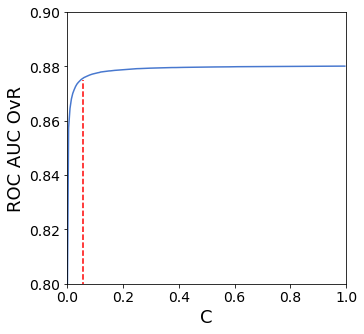

           C   avg_roc      diff
0   0.000001  0.788374       NaN
1   0.005001  0.857331  0.068956
2   0.010001  0.864491  0.007161
3   0.015001  0.867968  0.003477
4   0.020001  0.870076  0.002108
5   0.025001  0.871418  0.001341
6   0.030001  0.872601  0.001184
7   0.035001  0.873491  0.000890
8   0.040001  0.874119  0.000628
9   0.045001  0.874630  0.000511
10  0.050001  0.875158  0.000528
11  0.055001  0.875532  0.000374
12  0.060001  0.875869  0.000337
13  0.065001  0.876083  0.000214
14  0.070001  0.876341  0.000258


In [46]:
scores = [x for x in search.cv_results_['mean_test_score']]

# choose a best C
bestC = search.best_params_['logistic__C']
bestC = 0.055

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(5,5))
  plt.plot(C_vals, scores)
  plt.xlabel('C')
  plt.ylabel('ROC AUC OvR')
  plt.xlim([0, 1])
  ymin = 0.80
  ymax = 0.875
  plt.ylim([ymin,0.9])
  plt.vlines(x=bestC,ymin=0,ymax=ymax,linestyles='dashed',colors='r')
  plt.show()

scoredf = pd.DataFrame({'C':C_vals,'avg_roc':scores})
scoredf['diff'] = scoredf.avg_roc.diff()
print(scoredf.iloc[:15,:])

#### test C value

roc_auc_ovr train: 0.8828820150812804
roc_auc_ovr validation: 0.8617434833753432
roc_auc_ovr test: 0.8763924369954385


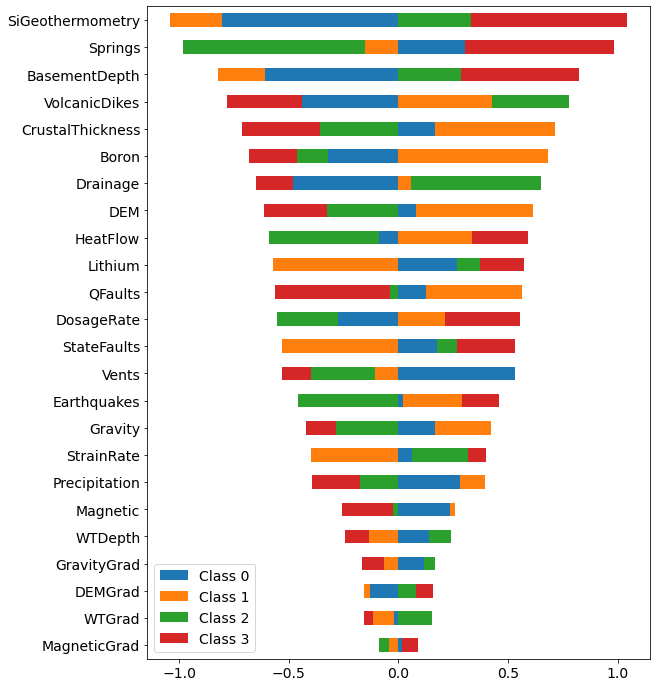

In [47]:
mod_logr = LogisticRegression(fit_intercept=True, 
                              multi_class='multinomial',
                              C=bestC,
                              random_state=seed,
                              solver='newton-cg')

# as noted earlier, StandardScaler and PowerTransformer both used to standardize
# to overcome bug that reduces 2 features to single values
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)
pipeline = Pipeline(steps=[('scale',sc),('powertransform',pt),('logistic',mod_logr)])
pipeline.fit(Xtr[colnames], yenc_trn)

print('roc_auc_ovr train: {}'.format(
  roc_auc_score(yenc_trn,
                pipeline.predict_proba(Xtr),
                multi_class='ovr')))

print('roc_auc_ovr validation: {}'.format(
  roc_auc_score(yenc_val,
                pipeline.predict_proba(Xvl),
                multi_class='ovr')))

print('roc_auc_ovr test: {}'.format(
  roc_auc_score(yenc_tst,
                pipeline.predict_proba(Xts),
                multi_class='ovr')))

# plot coefficients
coefdf = pd.DataFrame({'Class 0':pipeline.named_steps.logistic.coef_[0],'Class 1':pipeline.named_steps.logistic.coef_[1],'Class 2':pipeline.named_steps.logistic.coef_[2],'Class 3':pipeline.named_steps.logistic.coef_[3]},index=colnames)
coefdf['total'] = coefdf.apply(abs,axis=1).apply(sum,axis=1)
coefdf = coefdf.sort_values(by='total',ascending=True).drop('total',axis=1)
coefdf.plot.barh(stacked=True,figsize=(9,12),rot=0)
plt.legend(loc='best');#(0.015, .08))

### Feature Selection

In [48]:
models = {}
for i in range(2, len(colnames)+1):
  rfemod = LogisticRegression(fit_intercept=True, 
                              multi_class='multinomial',
                              C=bestC, 
                              random_state=seed,
                              solver='newton-cg')
  
  # as noted earlier, StandardScaler and PowerTransformer both used to standardize
  # to overcome bug that reduces 2 features to single values
  sc = StandardScaler()
  pt = PowerTransformer(method='yeo-johnson',standardize=True)
  rfe = RFE(estimator=rfemod, n_features_to_select=i)
  mymodel = LogisticRegression(fit_intercept=True, 
                               multi_class='multinomial',
                               C=bestC, 
                               random_state=seed,
                               solver='newton-cg')
  models[str(i)] = Pipeline(steps=[('scale',sc),('powertransform',pt),('s',rfe),('m',mymodel)])

rocvals, ncols = list(), list()
for nm, md in models.items():
  print('trying {} features'.format(nm))
  md.fit(Xtr, yenc_trn)
  ncols.append(nm)
  rocvals.append(roc_auc_score(yenc_val,md.predict_proba(Xvl), multi_class='ovr'))

trying 2 features
trying 3 features
trying 4 features
trying 5 features
trying 6 features
trying 7 features
trying 8 features
trying 9 features
trying 10 features
trying 11 features
trying 12 features
trying 13 features
trying 14 features
trying 15 features
trying 16 features
trying 17 features
trying 18 features
trying 19 features
trying 20 features
trying 21 features
trying 22 features
trying 23 features
trying 24 features


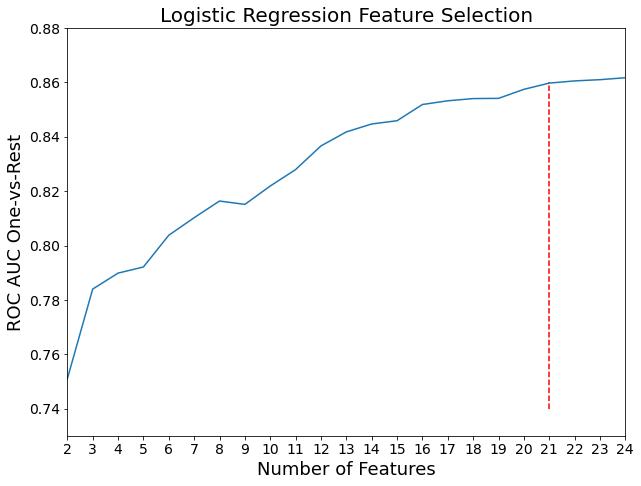

In [51]:
plt.figure(figsize=(10,7.5))
plt.plot(ncols,rocvals)
plt.vlines('21',ymin=0.74,ymax=0.86,linestyles='dashed',colors='r')
plt.ylim([0.73,0.88])
plt.xlim([ncols[0],ncols[-1]])
plt.title('Logistic Regression Feature Selection')
plt.xlabel('Number of Features');
plt.ylabel('ROC AUC One-vs-Rest');

#### Look for what gets thrown out

In [52]:
models = {}
nf = 21
rfemod = LogisticRegression(fit_intercept=True,
                            multi_class='multinomial',
                            C=bestC,
                            random_state=seed,
                            solver='newton-cg')
rfe = RFE(estimator=rfemod, n_features_to_select=nf)

mymodel = LogisticRegression(fit_intercept=True,
                             multi_class='multinomial',
                             C=bestC,
                             random_state=seed,
                             solver='newton-cg')

# as noted earlier, StandardScaler and PowerTransformer both used to standardize
# to overcome bug that reduces 2 features to single values
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)
rfepl = Pipeline(steps=[('scale',sc),('powertransform',pt),('s',rfe),('m',mymodel)])

rfepl.fit(Xtr, yenc_trn)
rocvals= roc_auc_score(yenc_val,rfepl.predict_proba(Xvl), multi_class='ovr')

In [53]:
print(rfepl.steps[2][1].support_)
print(rfepl.steps[2][1].ranking_)

print('Columns being kept: ',Xtrsc.columns[rfepl.steps[2][1].support_].to_list())
print('Columns being dropped: ',Xtrsc.columns[~rfepl.steps[2][1].support_].to_list())

fs_colnames = Xtrsc.columns[rfepl.steps[2][1].support_].to_list()

[ True False  True False  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[1 2 1 3 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Columns being kept:  ['DEM', 'Gravity', 'Magnetic', 'DosageRate', 'WTDepth', 'WTGrad', 'BasementDepth', 'CrustalThickness', 'Precipitation', 'StrainRate', 'QFaults', 'StateFaults', 'Drainage', 'VolcanicDikes', 'SiGeothermometry', 'Lithium', 'Boron', 'HeatFlow', 'Earthquakes', 'Vents', 'Springs']
Columns being dropped:  ['DEMGrad', 'GravityGrad', 'MagneticGrad']


In [54]:
fs_colnames = ['DEM', 
               'Gravity',
               'Magnetic',
               'DosageRate',
               'WTDepth',
               'WTGrad',
               'BasementDepth',
               'CrustalThickness',
               'Precipitation',
               'StrainRate',
               'QFaults', 
               'StateFaults',
               'Drainage',
               'VolcanicDikes',
               'SiGeothermometry',
               'Lithium',
               'Boron',
               'HeatFlow',
               'Earthquakes',
               'Vents',
               'Springs']

In [55]:
# refit final pipeline
mod_logr = LogisticRegression(fit_intercept=True, 
                              multi_class='multinomial',
                              C=bestC,
                              random_state=seed,
                              solver='newton-cg')

# as noted earlier, StandardScaler and PowerTransformer both used to standardize
# to overcome bug that reduces 2 features to single values
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson', standardize=True)
finLRpl= Pipeline(steps=[('scale',sc),('powertransform',pt),('logistic',mod_logr)])
finLRpl.fit(Xtr[fs_colnames], yenc_trn)

Pipeline(steps=[('scale', StandardScaler()),
                ('powertransform', PowerTransformer()),
                ('logistic',
                 LogisticRegression(C=0.055, multi_class='multinomial',
                                    random_state=43, solver='newton-cg'))])

### Plot ROCs


Model Results
Accuracy (Train) : 0.7032
Accuracy (Test)  : 0.687
F1-weighted (Train): 0.697510
F1-weighted (Test) : 0.675661
macro AUC (Train): 0.882088
weighted AUC (Train): 0.858912
macro AUC (Test) : 0.877885
weighted AUC (Test): 0.858366
[[ 14   4   2   8]
 [  1  47  35  53]
 [  0  34 201  69]
 [  0  11  34 289]]
              precision    recall  f1-score   support

       No-GT       0.93      0.50      0.65        28
      Low-GT       0.49      0.35      0.41       136
      Med-GT       0.74      0.66      0.70       304
     High-GT       0.69      0.87      0.77       334

    accuracy                           0.69       802
   macro avg       0.71      0.59      0.63       802
weighted avg       0.68      0.69      0.68       802



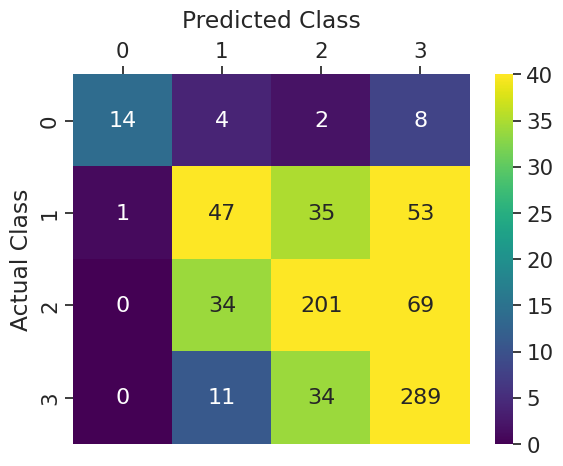

In [57]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

mod = finLRpl
xtrn = Xtr[fs_colnames]
ytrn = yenc_trn
xtst = Xts[fs_colnames]
ytst = yenc_tst

# predict
predprobs = mod.predict_proba(xtrn)
preds     = np.argmax(predprobs, axis=1)
predprobs_test = mod.predict_proba(xtst)
preds_test     = np.argmax(predprobs_test, axis=1)

# print stats
print("\nModel Results")
print("Accuracy (Train) : %.4g" % metrics.accuracy_score(ytrn, preds))
print("Accuracy (Test)  : %.4g" % metrics.accuracy_score(ytst, preds_test))
print("F1-weighted (Train): %f" % metrics.f1_score(ytrn, preds, average='weighted'))
print("F1-weighted (Test) : %f" % metrics.f1_score(ytst, preds_test,average='weighted'))
print("macro AUC (Train): %f" % metrics.roc_auc_score(ytrn, predprobs, average='macro', multi_class='ovr'))
print("weighted AUC (Train): %f" % metrics.roc_auc_score(ytrn, predprobs, average='weighted', multi_class='ovr'))
print("macro AUC (Test) : %f" % metrics.roc_auc_score(ytst, predprobs_test, average='macro', multi_class='ovr'))
print("weighted AUC (Test): %f" % metrics.roc_auc_score(ytst, predprobs_test, average='weighted', multi_class='ovr'))

# print confusion matrix
confusion = confusion_matrix(ytst, preds_test)
print(confusion)
print(classification_report(ytst, preds_test, 
                            target_names=['No-GT','Low-GT','Med-GT','High-GT']))

with mpl.style.context('default'):
  df_cm = pd.DataFrame(confusion, range(4), range(4))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, cmap='viridis',vmax=40,annot=True, 
              fmt='g', annot_kws={"size": 16}) # font size
  plt.xlabel('Predicted Class',labelpad=10)
  ax = plt.gca()
  ax.xaxis.set_label_position('top') 
  plt.ylabel('Actual Class',labelpad=5)
  ax.xaxis.tick_top()
  ax.yaxis.tick_left()
  plt.savefig(datafolder / 'LinearRegression_WDS8_ConfusionMatrix.png', bbox_inches='tight')
  plt.show()

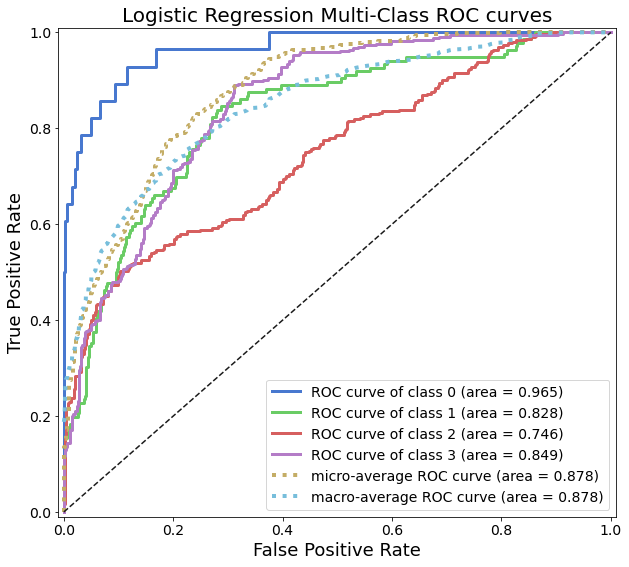

In [58]:
## from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#area-under-roc-for-the-multiclass-problem
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import matplotlib as mpl

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes=[0,1,2,3]
n_classes = len(classes)
yt_bin = label_binarize(yenc_tst, classes=classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yt_bin[:,i], mod.decision_function(Xts[fs_colnames])[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(yt_bin.ravel(), mod.decision_function(Xts[fs_colnames]).ravel())
#roc_auc['micro'] = metrics.roc_auc_score(yenc_tst, predprobs_test, average='micro',multi_class='ovr')
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = metrics.roc_auc_score(yenc_tst, predprobs_test, average='macro',multi_class='ovr')
#roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 3
with mpl.style.context("seaborn-muted"):
  plt.figure(figsize=(10,9))

  colors = cycle(['#4A67BF','#8C8C8C','#73A96C','#AD5153'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], lw=lw,   #color=color,lw=lw,alpha=.5,
              label='ROC curve of class {0} (area = {1:0.3f})'
              ''.format(i, roc_auc[i]))

  plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.3f})'
                  ''.format(roc_auc["micro"]),
            linestyle=':', lw=(lw+1))  #color='#C98AC1',alpha=.5

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
           linestyle=':', lw=(lw+1))  #color='#82B3CC', lw=lw,alpha=.5
           
  plt.plot([0, 1], [0, 1], 'k--') #, lw=lw, alpha=0.5
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Logistic Regression Multi-Class ROC curves')
  plt.legend(loc="lower right")
  plt.savefig(datafolder / 'LinearRegression_WDS8_ROCplot.png', bbox_inches='tight')
  plt.show()

 ## Apply Model on Full Data Set

In [ ]:
# load full map dataset
with open(datafolder/ "full_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
    
# unpack
FULLdf     = datadict['data']
FULLcoords = datadict['coords']
FULLdfsc = pd.DataFrame(pl.transform(FULLdf[colnames]), columns=colnames)

# refit final pipeline on all data
Xall   = pd.concat([Xtr,Xvl,Xts])
Xallsc = pd.concat([Xtrsc,Xvlsc,Xtssc])
yenc_all=np.append(np.append(yenc_trn,yenc_val),yenc_tst)

pfa_result = FULLdf['GeothermGrad_4class']
FULLdf = FULLdf[colnames]

In [ ]:
mod_logr = LogisticRegression(fit_intercept=True, 
                              multi_class='multinomial',
                              C=bestC,
                              random_state=seed,
                              solver='newton-cg')

# as noted earlier, StandardScaler and PowerTransformer both used to standardize
# to overcome bug that reduces 2 features to single values
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson', standardize=True)
mod_logr = Pipeline(steps=[('scale',sc),('powertransform',pt),('logistic',mod_logr)])
mod_logr.fit(Xall[fs_colnames], yenc_all)

Pipeline(steps=[('scale', StandardScaler()),
                ('powertransform', PowerTransformer()),
                ('logistic',
                 LogisticRegression(C=0.055, multi_class='multinomial',
                                    random_state=43, solver='newton-cg'))])

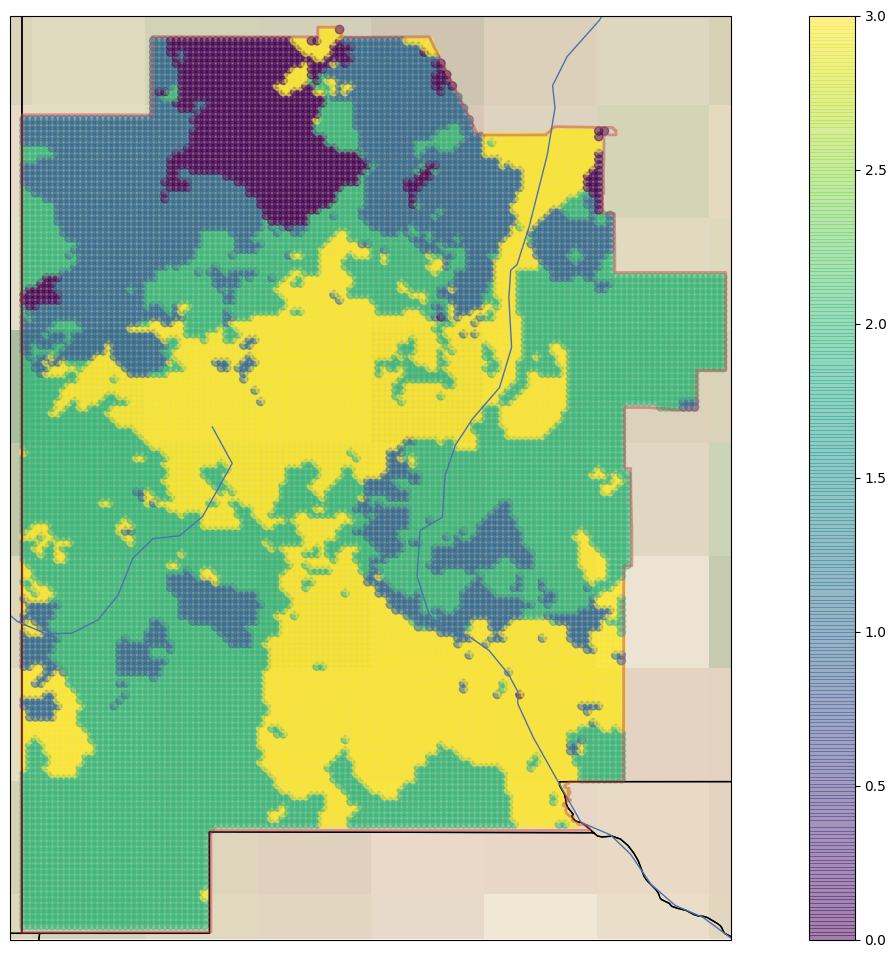

In [ ]:
# predict result
FULL_ypred = mod_logr.predict(FULLdf[fs_colnames])
FULL_ypred_proba = mod_logr.predict_proba(FULLdf[fs_colnames])

# plot result
with mpl.style.context('default'):
  ax = createBasemap();
  gdf = gpd.GeoDataFrame(FULLcoords, 
                        geometry=gpd.points_from_xy(FULLcoords.Longitude, FULLcoords.Latitude),
                        crs = {'init': 'epsg:4326'})
  pc = ax.scatter(FULLcoords.Longitude,
                  FULLcoords.Latitude,
                  c=FULL_ypred,
                  cmap='viridis',
                  alpha=0.5,
                  transform=myprojection);
  plt.colorbar(pc);
  #plt.savefig(datafolder / 'logisticregression_model_prediction_map.png')
  #plt.savefig(datafolder / 'logisticregression_model_prediction_map.pdf')

In [ ]:
# save out for use in other scripts
shared = {
          "coords":FULLcoords,
          "model":mod_logr,
          "full_dataset":FULLdf,
          "selected_columns":fs_colnames,
          "test_yc_pred":preds_test,
          "test_yc_pred_proba":predprobs_test,
          "full_yc_pred":FULL_ypred,
          "full_yc_pred_proba":FULL_ypred_proba
         }
#with open(datafolder / "gradient_class_prediction_logreg.pkl","wb") as handle:
#    pkl.dump(shared, handle, protocol=pkl.HIGHEST_PROTOCOL)

### Try including SMOTE for rebalancing dataset
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

print("initial class balance:")
counter = Counter(yc_train4)
for k,v in counter.items():
	per = v / len(yc_train4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

initial class balance:
Class=2, n=801 (38.491%)
Class=3, n=860 (41.326%)
Class=1, n=349 (16.771%)
Class=0, n=71 (3.412%)


In [ ]:
#OVERSAMP_RATE  = 0.25  # increase minority class to this % of dataset
#UNDERSAMP_RATE = 0.5  # reduce the majority class by this amount

# define pipeline
#over  = SMOTE(sampling_strategy=OVERSAMP_RATE)
over  = SMOTE('all')
#under = RandomUnderSampler(sampling_strategy=UNDERSAMP_RATE)
#steps = [('o', over), ('u', under)]
steps = [('o', over)]
smotepl = Pipeline(steps=steps)

# transform the dataset
Xsmote, ysmote = smotepl.fit_resample(Xtr[colnames], yc_train4)

# summarize the new class distribution
print("SMOTE rebalanced:")
counter = Counter(ysmote)
for k,v in counter.items():
	per = v / len(ysmote) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

SMOTE rebalanced:
Class=2, n=860 (25.000%)
Class=3, n=860 (25.000%)
Class=1, n=860 (25.000%)
Class=0, n=860 (25.000%)


#### Re-perform Logistic Regression with more balanced data set

In [ ]:
# re-fit encoder with SMOTE data set
le.fit(ysmote)
ysmote_enc_trn = le.transform(ysmote)
ysmote_enc_val = le.transform(yc_val['GeothermGrad_4class'].cat.codes)
ysmote_enc_tst = le.transform(yc_test4)

# run Logistic Regression
mod_logr = LogisticRegression(fit_intercept=True, 
                              multi_class='multinomial',
                              random_state=seed,
                              solver='newton-cg')

# include scaling and transformations as part of model pipeline
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)
pipeline = Pipeline(steps=[('scale',sc),('powertransform',pt),('logistic',mod_logr)])
param_grid = {
    'logistic__C': np.arange(0.000001,1.0, 0.005)
}

# tune hyperparameter (C)
search = GridSearchCV(pipeline, param_grid, 
                      n_jobs=-1, cv=10,
                      verbose=1, scoring='roc_auc_ovr')
search.fit(Xsmote, ysmote_enc_trn);

print("Best parameters: " + str(search.best_params_))
print("Using train data: score=%0.3f" % search.best_score_)
print("Using val data: score=%0.3f"  % search.best_estimator_.score(Xvl[colnames],ysmote_enc_val))
print("Using test data: score=%0.3f"  % search.best_estimator_.score(Xts[colnames],ysmote_enc_tst))

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best parameters: {'logistic__C': 0.990001}
Using train data: score=0.916
Using val data: score=0.677
Using test data: score=0.704


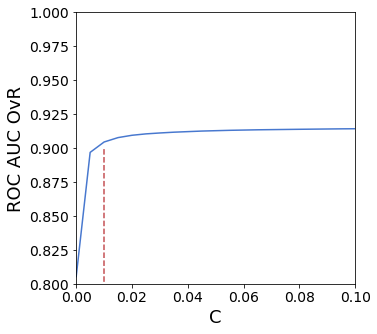

           C   avg_roc      diff
15  0.075001  0.913593  0.000123
16  0.080001  0.913693  0.000100
17  0.085001  0.913816  0.000123
18  0.090001  0.913949  0.000133
19  0.095001  0.914022  0.000073
20  0.100001  0.914092  0.000070
21  0.105001  0.914178  0.000086
22  0.110001  0.914243  0.000065
23  0.115001  0.914325  0.000082
24  0.120001  0.914393  0.000068
25  0.125001  0.914450  0.000057
26  0.130001  0.914488  0.000037
27  0.135001  0.914524  0.000036
28  0.140001  0.914560  0.000036
29  0.145001  0.914602  0.000043
30  0.150001  0.914643  0.000041
31  0.155001  0.914677  0.000034
32  0.160001  0.914675 -0.000002
33  0.165001  0.914734  0.000060
34  0.170001  0.914783  0.000048


In [ ]:
scores = [x for x in search.cv_results_['mean_test_score']]

# choose a best C
bestC = search.best_params_['logistic__C']
bestC = 0.010

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(5,5))
  plt.plot(C_vals, scores)
  plt.xlabel('C')
  plt.ylabel('ROC AUC OvR')
  plt.xlim([0, .1])
  plt.ylim([0.8,1.0])
  ymax = 0.9
  plt.vlines(x=bestC,ymin=0,ymax=ymax,linestyles='dashed',colors='r')
  plt.show()

scoredf = pd.DataFrame({'C':C_vals,'avg_roc':scores})
scoredf['diff'] = scoredf.avg_roc.diff()
print(scoredf.iloc[15:35,:])

In [ ]:
# refit final pipeline
mod_logr = LogisticRegression(fit_intercept=True, 
                              multi_class='multinomial',
                              C=bestC,
                              random_state=seed,
                              solver='newton-cg')

# as noted earlier, StandardScaler and PowerTransformer both used to standardize
# to overcome bug that reduces 2 features to single values
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson', standardize=True)
smoteLRpl= Pipeline(steps=[('scale',sc),('powertransform',pt),('logistic',mod_logr)])
smoteLRpl.fit(Xsmote[fs_colnames], ysmote_enc_trn);

smotepredprobs      = smoteLRpl.predict_proba(Xsmote[fs_colnames])
smotepreds          = np.argmax(smotepredprobs, axis=1)
smotepredprobs_test = smoteLRpl.predict_proba(Xts[fs_colnames])
smotepreds_test     = np.argmax(smotepredprobs_test, axis=1)

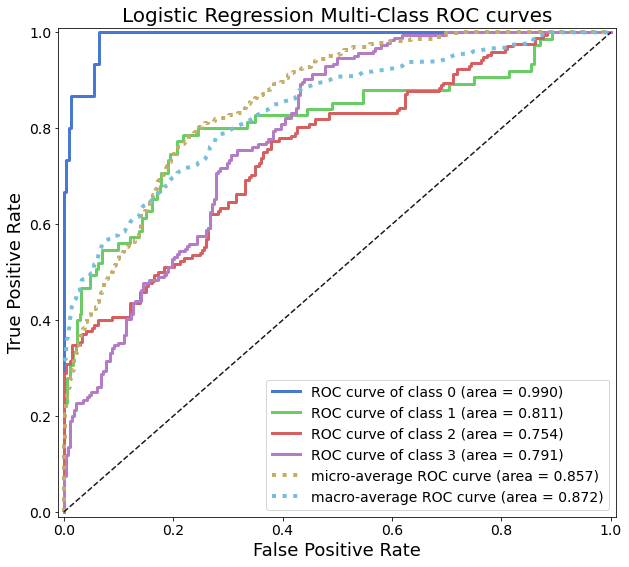

In [ ]:
## from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#area-under-roc-for-the-multiclass-problem
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import matplotlib as mpl

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes=[0,1,2,3]
n_classes = len(classes)
yt_bin = label_binarize(ysmote_enc_tst, classes=classes)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yt_bin[:,i], smoteLRpl.decision_function(Xts[fs_colnames])[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(yt_bin.ravel(), smoteLRpl.decision_function(Xts[fs_colnames]).ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = metrics.roc_auc_score(yenc_tst, smotepredprobs_test, average='macro',multi_class='ovr')
#roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 3
with mpl.style.context("seaborn-muted"):
  plt.figure(figsize=(10,9))

  colors = cycle(['#4A67BF','#8C8C8C','#73A96C','#AD5153'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], lw=lw,   #color=color,lw=lw,alpha=.5,
              label='ROC curve of class {0} (area = {1:0.3f})'
              ''.format(i, roc_auc[i]))

  plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.3f})'
                  ''.format(roc_auc["micro"]),
            linestyle=':', lw=(lw+1))  #color='#C98AC1',alpha=.5

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
           linestyle=':', lw=(lw+1))  #color='#82B3CC', lw=lw,alpha=.5
           
  plt.plot([0, 1], [0, 1], 'k--') #, lw=lw, alpha=0.5
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Logistic Regression Multi-Class ROC curves')
  plt.legend(loc="lower right")
  plt.show()

#### Based on validation and test case results, SMOTE is not as good